In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

(1859, 1752, 3)


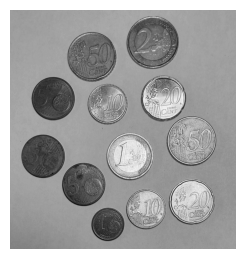

In [3]:
###################################
#        Carga de imagenes        #
###################################

# Carga la imagen de las monedas con fondo ruidoso
img = cv2.imread('Monedas2.jpeg')
#img = cv2.imread('Monedas.jpg')
#img = cv2.imread("Monedas_con_objetos.jpeg")

# Verificar las dimensiones de la imagen
print(img.shape)

###################################
#       Conversión a grises       #
###################################

# Convertimos la imagen a escala de grises
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img_gris, cmap='gray')


plt.show()


Umbral fijo usado  200.0
Umbral Otsu  117.0


Text(0.5, 1.0, 'OTSU invertida')

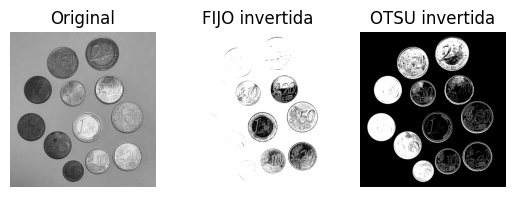

In [4]:
#Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
umbral = 200 # Prueba varios comenzando en 130
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
print('Umbral fijo usado ', th1)
# Umbralizado con método de Otsu para selección automática del umbral
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Umbral Otsu ', th2)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 centimos de 24.35, la de 20 centimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

Moneda seleccionada con diámetro en píxeles: 377.2065124511719
Relación píxeles/mm: 16.22393601940524
Monedas detectadas: 12
Cantidad total de dinero: 4.76€

Monedas clasificadas:
1 moneda(s) de 0.01€
3 moneda(s) de 0.05€
2 moneda(s) de 0.1€
2 moneda(s) de 0.2€
2 moneda(s) de 0.5€
1 moneda(s) de 1.0€
1 moneda(s) de 2.0€


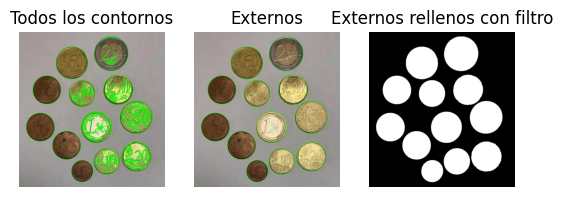

In [5]:
#######################################
#  Filtrado de objetos por contornos  #
#######################################

contornos_redondos = []
diametros_monedas = []

# Aplicar un suavizado Gaussiano para eliminar el ruido antes de la detección de contornos
img_blur = cv2.GaussianBlur(img_th2, (7, 7), 0)


# Obtiene todos los contornos: externos e internos
contornos, hierarchy = cv2.findContours(
    img_blur, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )

# Dibuja sobre la imagen de entrada los contornos en verde
# Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

# Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_blur, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada solo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

# Dibuja contornos externos rellenos en imagen vacía
# Imagen negra
img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)

# Recorre los contornos externos
for c in contornos2:
    # Área del contorno
    area = cv2.contourArea(c)
    # Área mínima (útil filtrar en ocasiones)
    if area > 300:
        # Perímetro del contorno
        perimetro = cv2.arcLength(c,True)

        # Calcular la relación entre el área y el cuadrado del perímetro
        relacion_redondez = (4 * np.pi * area) / (perimetro ** 2)
    
        # Define un umbral más alto para asegurar que sean solo bordes redondos
        umbral_redondez = 0.80
        if relacion_redondez > umbral_redondez:
            contornos_redondos.append(c)

            # Determinar el valor de la moneda en función de su diámetro
            (x, y), radio = cv2.minEnclosingCircle(c)

            # Calcula el diámetro a partir del radio
            diametro = 2 * radio
            diametros_monedas.append(diametro)

            # Dibuja los contornos redondos filtrados
            cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)


# Función para manejar el clic del usuario en la imagen
def seleccionar_moneda(event, x, y, flags, param):
    global diametro_seleccionado
    if event == cv2.EVENT_LBUTTONDOWN:
        for c in contornos_redondos:
            # Comprueba si el punto está dentro del contorno
            if cv2.pointPolygonTest(c, (x, y), False) >= 0:
                # Encuentra el círculo que mejor se ajusta al contorno
                (cx, cy), radio = cv2.minEnclosingCircle(c)
                diametro_seleccionado = 2 * radio
                print(f"Moneda seleccionada con diámetro en píxeles: {diametro_seleccionado}")

# Función para identificar el valor de la moneda basado en su diámetro
def identificar_moneda(diametro_mm):
    if abs(diametro_mm - 16.25) < 0.6:
        return 0.01  # 1 céntimo
    elif abs(diametro_mm - 18.75) < 0.6:
        return 0.02  # 2 céntimos
    elif abs(diametro_mm - 21.25) < 0.6:
        return 0.05  # 5 céntimos
    elif abs(diametro_mm - 19.75) < 0.6:
        return 0.10  # 10 céntimos
    elif abs(diametro_mm - 22.25) < 0.6:
        return 0.20  # 20 céntimos
    elif abs(diametro_mm - 24.35) < 0.6:
        return 0.50  # 50 céntimos
    elif abs(diametro_mm - 23.25) < 0.6:
        return 1.0  # 1 Euro
    elif abs(diametro_mm - 25.75) < 0.6:
        return 2.0  # 2 Euros
    return 0.0  # No es una moneda válida

# Diccionario para almacenar la cantidad de cada tipo de moneda detectada
monedas_detectadas = {
    0.01: 0,
    0.02: 0,
    0.05: 0,
    0.10: 0,
    0.20: 0,
    0.50: 0,
    1.00: 0,
    2.00: 0
}

# Mostrar imagen para la selección de una moneda
cv2.namedWindow("Seleccione una moneda haciendo clic", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Seleccione una moneda haciendo clic", 800, 600)
cv2.imshow("Seleccione una moneda haciendo clic", img_rgb)
cv2.setMouseCallback("Seleccione una moneda haciendo clic", seleccionar_moneda)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Asumir que se ha seleccionado una moneda con un diámetro conocido
diametro_seleccionado_mm = 23.25  # Para una moneda de 1 Euro

# Calcular la relación píxeles/mm
relacion_pixel_mm = diametro_seleccionado / diametro_seleccionado_mm
print(f"Relación píxeles/mm: {relacion_pixel_mm}")

# Identificar el valor de cada moneda detectada
valor_total = 0
for diametro in diametros_monedas:
    diametro_mm = diametro / relacion_pixel_mm
    valor_moneda = identificar_moneda(diametro_mm)
    valor_total += valor_moneda
    # Si la moneda es válida, incrementar el conteo en el diccionario
    if valor_moneda in monedas_detectadas:
        monedas_detectadas[valor_moneda] += 1

# Mostrar el número de monedas y el valor total
print(f"Monedas detectadas: {len(diametros_monedas)}")
print(f"Cantidad total de dinero: {valor_total:.2f}€")

# Imprimir las monedas clasificadas por tipo
print("\nMonedas clasificadas:")
for valor, cantidad in monedas_detectadas.items():
    if cantidad > 0:
        print(f"{cantidad} moneda(s) de {valor}€")

# Mostrar la imagen con contornos redondos resaltados
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Externos")

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos con filtro')

plt.show()


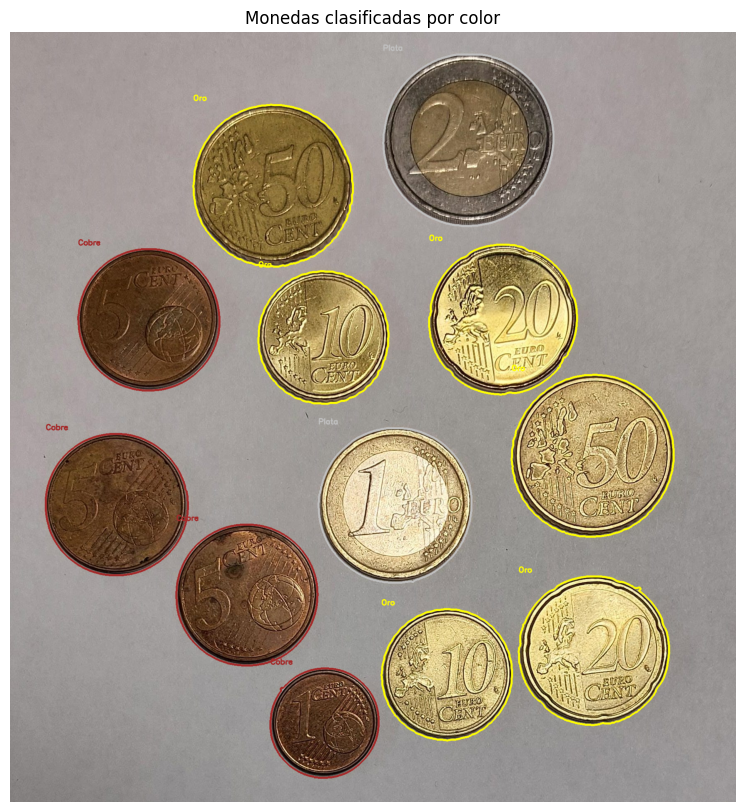

Monedas encontradas por color:
Monedas de oro: 6
Monedas de plata: 2
Monedas de cobre: 4
Diámetros de las monedas: [11.180540084838867, 267.4377746582031, 319.1904602050781, 370.1207275390625, 10.816854476928711, 343.7532958984375, 10.816854476928711, 345.9934997558594, 377.2065124511719, 9.434181213378906, 397.7043762207031, 322.28515625, 343.9363098144531, 364.7532043457031, 392.9649353027344, 418.74237060546875]


In [6]:
contornos_redondos = []
diametros_monedas = []
monedas_por_color = {"oro": 0, "plata": 0, "cobre": 0}

# Definir rangos de colores en el espacio HSV
rango_oro_bajo = np.array([20, 100, 100], np.uint8)   # Amarillo-dorado
rango_oro_alto = np.array([35, 255, 255], np.uint8)

rango_plata_bajo = np.array([0, 0, 200], np.uint8)    # Plateado-blanco
rango_plata_alto = np.array([180, 50, 255], np.uint8)

rango_cobre_bajo = np.array([5, 100, 100], np.uint8)  # Naranja-cobrizo
rango_cobre_alto = np.array([15, 255, 255], np.uint8)

# Convierte la imagen a espacio de color HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Crear una copia de la imagen original para dibujar los contornos clasificados
img_clasificada = img.copy()

# Definir colores para las diferentes monedas
color_oro = (0, 255, 255)  # Amarillo-dorado en BGR
color_plata = (192, 192, 192)  # Plateado-gris en BGR
color_cobre = (42, 42, 165)  # Marrón-cobrizo en BGR

# Procesar los contornos redondos
for c in contornos2:
    #Área del contorno
    area = cv2.contourArea(c)
    if area > 50:
        # Perímetro del contorno
        perimetro = cv2.arcLength(c,True)
        # Contenedor alineado con ejes de la imagen
        x, y, w, h = cv2.boundingRect(c)

        # Calcular la relación entre el área y el cuadrado del perímetro
        relacion_redondez = (4 * np.pi * area) / (perimetro ** 2)
        
        # Define un umbral para considerar que un contorno es redondo
        umbral_redondez = 0.80  
        if relacion_redondez > umbral_redondez:
            contornos_redondos.append(c)

            # Extrae la región de la moneda usando el bounding rect
            moneda_roi = img_hsv[y:y+h, x:x+w]

            # Máscaras de color para cada tipo de moneda
            mascara_oro = cv2.inRange(moneda_roi, rango_oro_bajo, rango_oro_alto)
            mascara_plata = cv2.inRange(moneda_roi, rango_plata_bajo, rango_plata_alto)
            mascara_cobre = cv2.inRange(moneda_roi, rango_cobre_bajo, rango_cobre_alto)

            # Cuenta cuántos píxeles pertenecen a cada color
            oro_pixels = cv2.countNonZero(mascara_oro)
            plata_pixels = cv2.countNonZero(mascara_plata)
            cobre_pixels = cv2.countNonZero(mascara_cobre)

            # Determina el color predominante
            if oro_pixels > plata_pixels and oro_pixels > cobre_pixels:
                monedas_por_color["oro"] += 1
                # Dibuja el contorno de la moneda en dorado
                cv2.drawContours(img_clasificada, [c], -1, color_oro, 3)
                # Añade texto indicando la clasificación
                cv2.putText(img_clasificada, "Oro", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_oro, 2)
            elif plata_pixels > oro_pixels and plata_pixels > cobre_pixels:
                monedas_por_color["plata"] += 1
                # Dibuja el contorno de la moneda en plateado
                cv2.drawContours(img_clasificada, [c], -1, color_plata, 3)
                # Añade texto indicando la clasificación
                cv2.putText(img_clasificada, "Plata", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_plata, 2)
            elif cobre_pixels > oro_pixels and cobre_pixels > plata_pixels:
                monedas_por_color["cobre"] += 1
                # Dibuja el contorno de la moneda en cobrizo
                cv2.drawContours(img_clasificada, [c], -1, color_cobre, 3)
                # Añade texto indicando la clasificación
                cv2.putText(img_clasificada, "Cobre", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_cobre, 2)

            # Determinar el valor de la moneda en función de su diámetro
            (cx, cy), radio = cv2.minEnclosingCircle(c)
            diametro = 2 * radio
            diametros_monedas.append(diametro)

# Mostrar la imagen con las monedas clasificadas por color
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(cv2.cvtColor(img_clasificada, cv2.COLOR_BGR2RGB))
plt.title('Monedas clasificadas por color')
plt.show()

# Mostrar los resultados en texto
print("Monedas encontradas por color:")
print(f"Monedas de oro: {monedas_por_color['oro']}")
print(f"Monedas de plata: {monedas_por_color['plata']}")
print(f"Monedas de cobre: {monedas_por_color['cobre']}")
print("Diámetros de las monedas:", diametros_monedas)


In [7]:
def apartado1(filePath:str):
    # Carga la imagen de las monedas con fondo ruidoso
    img = cv2.imread(filePath)

    # Convertimos la imagen a escala de grises
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Dos variantes de umbralizado. Probar otros parámetros, aplicar filtro previo, etc.
    umbral = 200 # Prueba varios comenzando en 130
    # Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
    th1,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
    # Umbralizado con método de Otsu para selección automática del umbral
    th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


    contornos_redondos = []
    diametros_monedas = []

    # Aplicar un suavizado Gaussiano para eliminar el ruido antes de la detección de contornos
    img_blur = cv2.GaussianBlur(img_th2, (7, 7), 0)

    #Obtiene todos los contornos: externos e internos
    contornos, hierarchy = cv2.findContours(
        img_blur, #imagen
        cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
        cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
        )

    #Dibuja sobre la imagen de entrada los contornos en verde
    #Cada vez que quiere pintar convierte img para no tener restos
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

    plt.subplot(131)
    plt.axis("off")
    plt.imshow(img_rgb) 
    plt.title('Todos los contornos')

    #Obtiene únicamente los contornos externos
    contornos2, hierarchy2 = cv2.findContours(img_blur, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)

    #Dibuja sobre la imagen de entrada sólo contornos externos
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

    plt.subplot(132)
    plt.axis("off")
    plt.imshow(img_rgb) 
    plt.title('Externos')

    #Dibuja contornos externos rellenos en imagen vacía
    #Imagen negra
    img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)

    #Recorre los contornos externos
    for c in contornos2:
        # Área del contorno
        area = cv2.contourArea(c)
        # Área mínima (útil filtrar en ocasiones)
        if area > 300:
            # Perímetro del contorno
            perimetro = cv2.arcLength(c,True)
    
            # Calcular la relación entre el área y el cuadrado del perímetro
            relacion_redondez = (4 * np.pi * area) / (perimetro ** 2)
        
            # Define un umbral más alto para asegurar que sean solo bordes redondos
            umbral_redondez = 0.80
            if relacion_redondez > umbral_redondez:
                contornos_redondos.append(c)
    
                # Determinar el valor de la moneda en función de su diámetro
                (x, y), radio = cv2.minEnclosingCircle(c)
    
                # Calcula el diámetro a partir del radio
                diametro = 2 * radio
                diametros_monedas.append(diametro)
    
                # Dibuja los contornos redondos filtrados
                cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
    

    # Función para manejar el clic del usuario en la imagen
    def seleccionar_moneda(event, x, y, flags, param):
        global diametro_seleccionado
        if event == cv2.EVENT_LBUTTONDOWN:
            for c in contornos_redondos:
                # Comprueba si el punto está dentro del contorno
                if cv2.pointPolygonTest(c, (x, y), False) >= 0:
                    # Encuentra el círculo que mejor se ajusta al contorno
                    (cx, cy), radio = cv2.minEnclosingCircle(c)
                    diametro_seleccionado = 2 * radio
                    print(f"Moneda seleccionada con diámetro en píxeles: {diametro_seleccionado}")

    # Función para identificar el valor de la moneda basado en su diámetro
    def identificar_moneda(diametro_mm):
        if abs(diametro_mm - 16.25) < 0.6:
            return 0.01  # 1 céntimo
        elif abs(diametro_mm - 18.75) < 0.6:
            return 0.02  # 2 céntimos
        elif abs(diametro_mm - 21.25) < 0.6:
            return 0.05  # 5 céntimos
        elif abs(diametro_mm - 19.75) < 0.6:
            return 0.10  # 10 céntimos
        elif abs(diametro_mm - 22.25) < 0.6:
            return 0.20  # 20 céntimos
        elif abs(diametro_mm - 24.35) < 0.6:
            return 0.50  # 50 céntimos
        elif abs(diametro_mm - 23.25) < 0.6:
            return 1.0  # 1 Euro
        elif abs(diametro_mm - 25.75) < 0.6:
            return 2.0  # 2 Euros
        return 0.0  # No es una moneda válida


    # Diccionario para almacenar la cantidad de cada tipo de moneda detectada
    monedas_detectadas = {
        0.01: 0,
        0.02: 0,
        0.05: 0,
        0.10: 0,
        0.20: 0,
        0.50: 0,
        1.00: 0,
        2.00: 0
    }

    # Fijar un tamaño para la ventana
    cv2.namedWindow("Seleccione una moneda haciendo clic", cv2.WINDOW_NORMAL)  # Crear una ventana con tamaño ajustable
    cv2.resizeWindow("Seleccione una moneda haciendo clic", 800, 600)  # Fijar tamaño a 800x600 píxeles
    
    # Mostrar la imagen para la selección de una moneda
    cv2.imshow("Seleccione una moneda haciendo clic", img_rgb)
    cv2.setMouseCallback("Seleccione una moneda haciendo clic", seleccionar_moneda)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


    # Asumir que se ha seleccionado una moneda con un diámetro conocido
    diametro_seleccionado_mm = 23.25  # Para una moneda de 1 Euro

    # Calcular la relación píxeles/mm
    relacion_pixel_mm = diametro_seleccionado / diametro_seleccionado_mm
    print(f"Relación píxeles/mm: {relacion_pixel_mm}")

    # Identificar el valor de cada moneda detectada
    valor_total = 0
    for diametro in diametros_monedas:
        diametro_mm = diametro / relacion_pixel_mm
        valor_moneda = identificar_moneda(diametro_mm)
        valor_total += valor_moneda
        # Si la moneda es válida, incrementar el conteo en el diccionario
        if valor_moneda in monedas_detectadas:
            monedas_detectadas[valor_moneda] += 1

    # Mostrar el número de monedas y el valor total
    print(f"Monedas detectadas: {len(diametros_monedas)}")
    print(f"Cantidad total de dinero: {valor_total:.2f}€")

    # Imprimir las monedas clasificadas por tipo
    print("\nMonedas clasificadas:")
    for valor, cantidad in monedas_detectadas.items():
        if cantidad > 0:
            print(f"{cantidad} moneda(s) de {valor}€")

    # Mostrar la imagen con contornos redondos resaltados
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Externos")


    plt.subplot(133)
    plt.axis("off")
    plt.imshow(img_cont) 
    plt.title('Externos rellenos')
    plt.show()



Relación píxeles/mm: 16.22393601940524
Monedas detectadas: 8
Cantidad total de dinero: 0.00€

Monedas clasificadas:


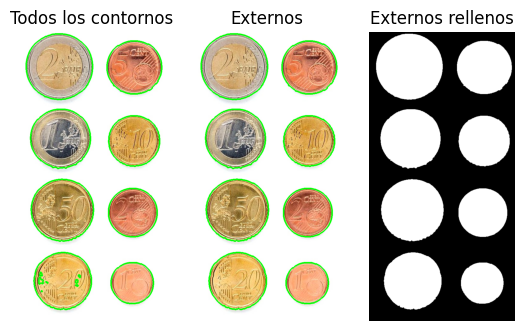

Relación píxeles/mm: 16.22393601940524
Monedas detectadas: 5
Cantidad total de dinero: 0.30€

Monedas clasificadas:
1 moneda(s) de 0.1€
1 moneda(s) de 0.2€


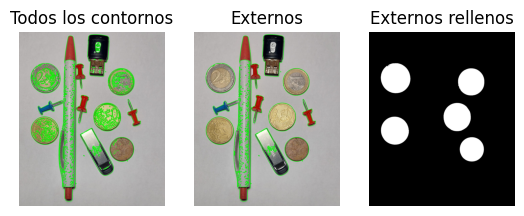

In [8]:
apartado1("Monedas.jpg")
apartado1("Monedas_con_objetos.jpeg")

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

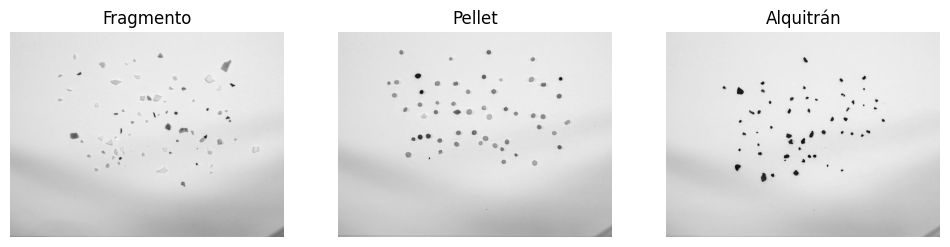

In [13]:
# Cargar de imágenes: fragmentos, pellets y alquitrán
frag_img = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pel_img = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
tar_img = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Convertir las imágenes a escala de grises
frag_gris = cv2.cvtColor(frag_img, cv2.COLOR_BGR2GRAY)
pel_gris = cv2.cvtColor(pel_img, cv2.COLOR_BGR2GRAY)
tar_gris = cv2.cvtColor(tar_img, cv2.COLOR_BGR2GRAY)

# Aplicar un filtro de suavizado
frag_gris = cv2.GaussianBlur(frag_gris, (25, 25), 0)

# Mostrar las imágenes
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Fragmento')
plt.axis("off")
plt.imshow(frag_gris,cmap='gray') 

plt.subplot(1, 3, 2)
plt.title('Pellet')
plt.axis("off")
plt.imshow(pel_gris,cmap='gray') 

plt.subplot(1, 3, 3)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(tar_gris,cmap='gray') 

plt.show()

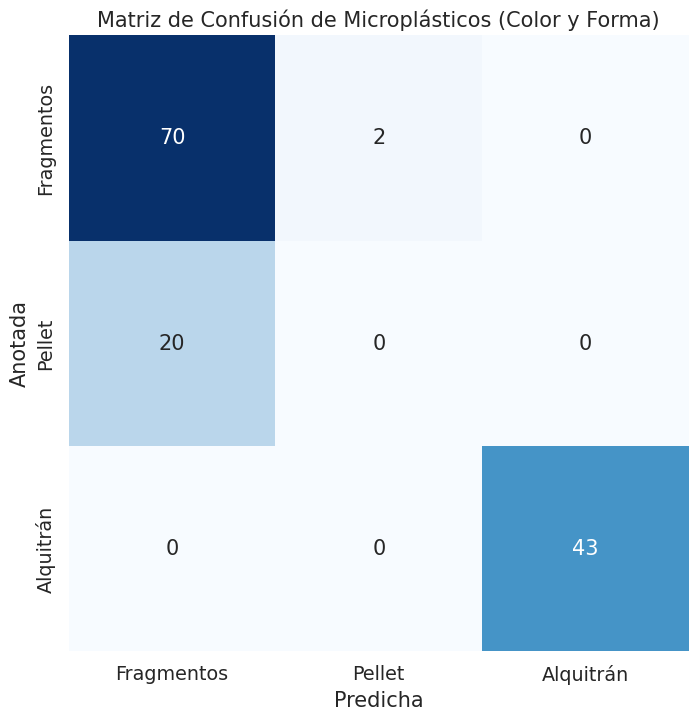

In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Función para umbralizar la imagen automáticamente con un filtro morfológico
def umbralizar_automatico(imagen):
    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Aplicar desenfoque Gaussiano para reducir el ruido
    desenfoque = cv2.GaussianBlur(gris, (5, 5), 0)
    
    # Usar umbralización automática de Otsu
    _, umbral = cv2.threshold(desenfoque, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Aplicar operaciones morfológicas para eliminar ruido pequeño
    kernel = np.ones((3, 3), np.uint8)
    umbral = cv2.morphologyEx(umbral, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return umbral

# Función para clasificar los objetos según sus características
def clasificar_objetos(imagen, imagen_umbralizada, area_min=100, area_max=3000):

    # Convertir a espacio de color HSV para analizar los colores
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)

    # Encontrar los contornos en la imagen
    contornos, _ = cv2.findContours(imagen_umbralizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Contar elementos de cada clase (fragmentos, pellets, alquitrán)
    fragmentos = 0  
    pellet = 0 
    alquitran = 0

    for contorno in contornos:
        # Área del contorno
        area = cv2.contourArea(contorno)

        # Filtrar contornos por área mínima y máxima
        if area < area_min or area > area_max:
            continue  # Saltar los contornos que no están dentro del rango

        # Obtener la máscara del contorno para analizar el color
        mask = np.zeros(imagen_hsv.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [contorno], -1, 255, -1)
        
        # Obtener el color promedio dentro del contorno en el espacio HSV
        mean_color = cv2.mean(imagen_hsv, mask=mask)[:3]
        mean_brightness = mean_color[2]  # El valor de V en el espacio HSV (brillo)

        # Si el brillo es muy bajo, clasificar como alquitrán (negro)
        if mean_brightness < 50:
            alquitran += 1
            continue

        # Perímetro del contorno
        perimetro = cv2.arcLength(contorno, True)

        # Contenedor alineado con ejes de la imagen (Bounding Box)
        _, _, w, h = cv2.boundingRect(contorno)

        # Mínimo círculo que lo contiene
        (cx, cy), radio = cv2.minEnclosingCircle(contorno)

        # Calcula la compacidad
        compacidad = (perimetro ** 2) / area if area > 0 else 0

        # Calcula la relación de aspecto
        relacion_aspecto = w / h

        # Clasificación según las características geométricas
        if compacidad < 15.0 and np.isclose(relacion_aspecto, 1.0, rtol=1.3):
            pellet += 1  # Clasificar como pellet
        else:
            fragmentos += 1  # Formas más irregulares

    return [fragmentos, pellet, alquitran]

# Cargar las imágenes
imagen_fra = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
imagen_pel = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
imagen_tar = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Aplicar umbralizado automático con filtrado morfológico
umbral_fragmentos = umbralizar_automatico(imagen_fra)
umbral_pel = umbralizar_automatico(imagen_pel)
umbral_tar = umbralizar_automatico(imagen_tar)

# Contar y clasificar elementos en cada imagen
conteo_frag = clasificar_objetos(imagen_fra, umbral_fragmentos)
conteo_pel = clasificar_objetos(imagen_pel, umbral_pel)
conteo_tar = clasificar_objetos(imagen_tar, umbral_tar)

# Crear una matriz de confusión basada en el conteo
matriz_confusion = np.array([conteo_frag, conteo_pel, conteo_tar])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Blues', 
            xticklabels=['Fragmentos', 'Pellet', 'Alquitrán'], 
            yticklabels=['Fragmentos', 'Pellet', 'Alquitrán'])
plt.xlabel("Predicha")
plt.ylabel("Anotada")
plt.title("Matriz de Confusión de Microplásticos (Color y Forma)")
plt.show()


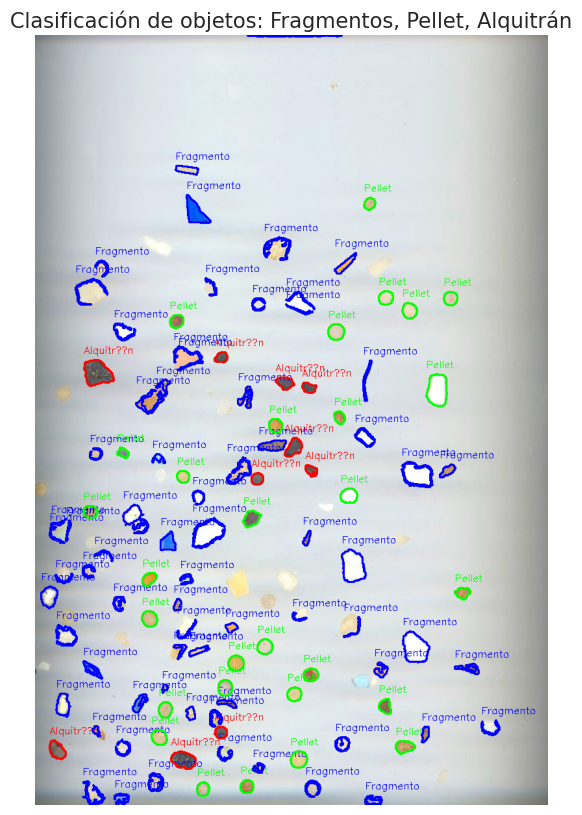

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para intensificar los colores mediante aumento de saturación
def intensificar_colores(img):
    # Convertir la imagen de BGR a HSV
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Aumentar la saturación multiplicando el canal de saturación por un factor (1.5, por ejemplo)
    img_hsv[:, :, 1] = cv2.multiply(img_hsv[:, :, 1], 1.5)
    
    # Limitar valores entre 0 y 255 para evitar saturación fuera de rango
    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 255)
    
    # Convertir la imagen de vuelta a BGR
    img_bgr_intensificada = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    
    return img_bgr_intensificada

# Función para detectar si un objeto es alquitrán basándonos en el color oscuro (negro/marrón oscuro)
def es_alquitran_rgb(img, contorno):
    # Crear una máscara para el contorno
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [contorno], -1, 255, -1)
    
    # Extraer el color promedio dentro del contorno en el espacio RGB
    mean_color = cv2.mean(img, mask=mask)[:3]  # R, G, B
    
    # Ajustar umbrales de color oscuro en RGB
    umbral_rgb_bajo = (0, 0, 0)   # Rango bajo (negro/marrón oscuro)
    umbral_rgb_alto = (120, 120, 120)  # Reducimos para incluir solo tonos más oscuros
    
    # Verificar si el color promedio está en el rango oscuro
    if umbral_rgb_bajo[0] <= mean_color[0] <= umbral_rgb_alto[0] and \
       umbral_rgb_bajo[1] <= mean_color[1] <= umbral_rgb_alto[1] and \
       umbral_rgb_bajo[2] <= mean_color[2] <= umbral_rgb_alto[2]:
        return True
    return False

# Función para detectar si un objeto es un Pellet (casi redondo)
def es_pellet(compacidad, relacion_ejes):
    return compacidad < 18 and relacion_ejes < 1.2

# Cargar la imagen y preprocesarla
def cargar_y_preprocesar_imagen(ruta_imagen):
    # Cargar la imagen
    img = cv2.imread(ruta_imagen)

    # Intensificar los colores antes de continuar
    img_intensificada = intensificar_colores(img)

    # Convertir a escala de grises
    img_gris = cv2.cvtColor(img_intensificada, cv2.COLOR_BGR2GRAY)

    # Aplicar suavizado Gaussiano
    img_blur = cv2.GaussianBlur(img_gris, (5, 5), 0)

    # Aplicar umbralización adaptativa
    img_bin = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 11, 2)
    
    return img_intensificada, img_bin

# Función para clasificar los objetos en la imagen
def clasificar_objetos(img, img_bin):
    # Encontrar todos los contornos
    contornos, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Listas para guardar la clasificación
    clasificaciones = []

    # Recorremos todos los contornos detectados
    for contorno in contornos:
        # Calcular el área y el perímetro
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        
        if area < 60:  # Ignorar áreas pequeñas
            continue
        
        # Calcular compacidad (bordes casi redondos vs irregulares)
        compacidad = (perimetro**2) / area

        # Ajustar una elipse si hay suficientes puntos
        if len(contorno) >= 5:
            elipse = cv2.fitEllipse(contorno)
            (x_elp, y_elp), (mayor_eje, menor_eje), angulo = elipse
            relacion_ejes = mayor_eje / menor_eje
        else:
            relacion_ejes = 1  # Si no es posible ajustar una elipse, se considera 1
        
        # Clasificación basada en color y geometría
        if es_alquitran_rgb(img, contorno):
            clasificacion = "Alquitrán"
            color = (0, 0, 255)  # Rojo para Alquitrán
        elif es_pellet(compacidad, relacion_ejes):
            clasificacion = "Pellet"
            color = (0, 255, 0)  # Verde para Pellets
        else:
            clasificacion = "Fragmento"
            color = (255, 0, 0)  # Azul para Fragmentos

        # Dibujar los contornos y clasificaciones en la imagen
        cv2.drawContours(img, [contorno], -1, color, 2)
        x, y, w, h = cv2.boundingRect(contorno)
        cv2.putText(img, clasificacion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Guardar la clasificación
        clasificaciones.append((clasificacion, area, perimetro, compacidad, relacion_ejes))
    
    return img, clasificaciones

# Función principal para ejecutar el proceso completo
def clasificador(ruta_imagen):
    # Cargar y preprocesar la imagen
    img, img_bin = cargar_y_preprocesar_imagen(ruta_imagen)

    # Clasificar los objetos
    img_clasificada, clasificaciones = clasificar_objetos(img, img_bin)

    # Mostrar la imagen clasificada
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img_clasificada, cv2.COLOR_BGR2RGB))
    plt.title("Clasificación de objetos: Fragmentos, Pellet, Alquitrán")
    plt.show()

ruta_imagen = 'MPs.jpg' 
clasificador(ruta_imagen)